<a href="https://colab.research.google.com/github/woncoh1/era1a7/blob/main/nbs/S7_03_dwsc_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Summary of targets, results, and analysis

## Targets
- Reduce the number of parameters

## Results
- Best accuracy
    - Train = 99.20 %
    - [ ] Test = 99.02 %
- [ ] Number of Parameters = 9,752
- [x] Number of Epochs = 15

## Analysis
- In order to radically reduce the number of parameters while maintaining accuracy, we converted all 3x3 convolution layers with depthwise separable layers. This resulted in nearly 75 % decrease in model size.
- Obviously, this reduced both the training and test accuracies, but not much, so we may crank them back up using fewer parameters than before.
- Surprisingly, reducing model size seems to act as regularization; we see a lot less over-fitting.

>[Summary](#scrollTo=kjFgf9woqfAE)

>>[Targets](#scrollTo=kjFgf9woqfAE)

>>[Results](#scrollTo=kjFgf9woqfAE)

>>[Analysis](#scrollTo=kjFgf9woqfAE)

>[Device](#scrollTo=7QlJ9s_43tj4)

>>[Colab](#scrollTo=_qZEo7Ty13uh)

>>[Pytorch](#scrollTo=30q5EOnt11t3)

>[Data](#scrollTo=IZlN9TTM3yVC)

>>[Transform](#scrollTo=lDnD-zELz8as)

>>[Dataset](#scrollTo=N4NSVJ0DwivZ)

>>[DataLoader](#scrollTo=vb2R5ZBFzi08)

>>[Inspect](#scrollTo=WD-_p0o7PQN_)

>[Model](#scrollTo=5v1EC4vo3upW)

>[Trainer](#scrollTo=_KvOD_jk3zrp)

>[Evaluate](#scrollTo=BoqfYvTXUPFb)



In [1]:
!git clone https://github.com/woncoh1/era1a7.git

Cloning into 'era1a7'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 67 (delta 36), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), 22.73 KiB | 495.00 KiB/s, done.


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary

from era1a7 import data, models, engine, utils

In [3]:
torch.manual_seed(1)

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.ToTensor(), # Standardization
        transforms.Normalize((0.1307,), (0.3081,)), # Normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]),
}

## Dataset

In [6]:
dataset = data.get_dataset(transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 92912846.10it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111955354.74it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24856563.58it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## DataLoader

In [7]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [8]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

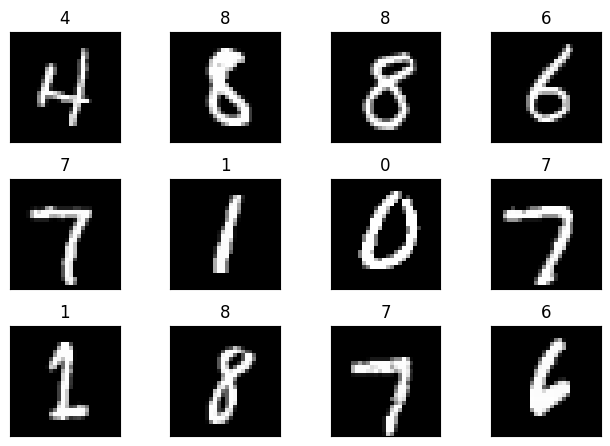

In [9]:
utils.inspect_batch(loader['train'])

# Model

In [10]:
criterion = F.nll_loss
model = models.Model2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]               9
              ReLU-2            [-1, 1, 26, 26]               0
       BatchNorm2d-3            [-1, 1, 26, 26]               2
         Dropout2d-4            [-1, 1, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]               8
              ReLU-6            [-1, 8, 26, 26]               0
       BatchNorm2d-7            [-1, 8, 26, 26]              16
         Dropout2d-8            [-1, 8, 26, 26]               0
            Conv2d-9            [-1, 8, 24, 24]              72
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
        Dropout2d-12            [-1, 8, 24, 24]               0
           Conv2d-13           [-1, 16, 24, 24]             128
             ReLU-14           [-1, 16,

# Trainer

In [11]:
params_trainer = {
    'num_epochs': 15,
}
params_optimizer = {
    'lr': 0.5,
    'momentum': 0.9,
}
params_scheduler = {
    'step_size': 10,
    'gamma': 0.1,
    'verbose': True,
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

Adjusting learning rate of group 0 to 5.0000e-01.


  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00208, Accuracy = 91.66%, Epoch = 1
Test : Loss = 0.00322, Accuracy = 87.19%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00082, Accuracy = 96.83%, Epoch = 2
Test : Loss = 0.00081, Accuracy = 96.52%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00060, Accuracy = 97.61%, Epoch = 3
Test : Loss = 0.00348, Accuracy = 87.54%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00055, Accuracy = 97.80%, Epoch = 4
Test : Loss = 0.00212, Accuracy = 92.49%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00049, Accuracy = 98.09%, Epoch = 5
Test : Loss = 0.00579, Accuracy = 81.79%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00047, Accuracy = 98.14%, Epoch = 6
Test : Loss = 0.00215, Accuracy = 90.89%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00044, Accuracy = 98.17%, Epoch = 7
Test : Loss = 0.00043, Accuracy = 98.28%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00041, Accuracy = 98.44%, Epoch = 8
Test : Loss = 0.00264, Accuracy = 90.53%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00039, Accuracy = 98.40%, Epoch = 9
Test : Loss = 0.00056, Accuracy = 97.98%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00038, Accuracy = 98.52%, Epoch = 10
Test : Loss = 0.00107, Accuracy = 95.83%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00024, Accuracy = 99.03%, Epoch = 11
Test : Loss = 0.00027, Accuracy = 98.94%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00021, Accuracy = 99.13%, Epoch = 12
Test : Loss = 0.00026, Accuracy = 98.94%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00020, Accuracy = 99.20%, Epoch = 13
Test : Loss = 0.00026, Accuracy = 98.90%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00020, Accuracy = 99.15%, Epoch = 14
Test : Loss = 0.00025, Accuracy = 99.02%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00019, Accuracy = 99.19%, Epoch = 15
Test : Loss = 0.00025, Accuracy = 98.98%



# Evaluate

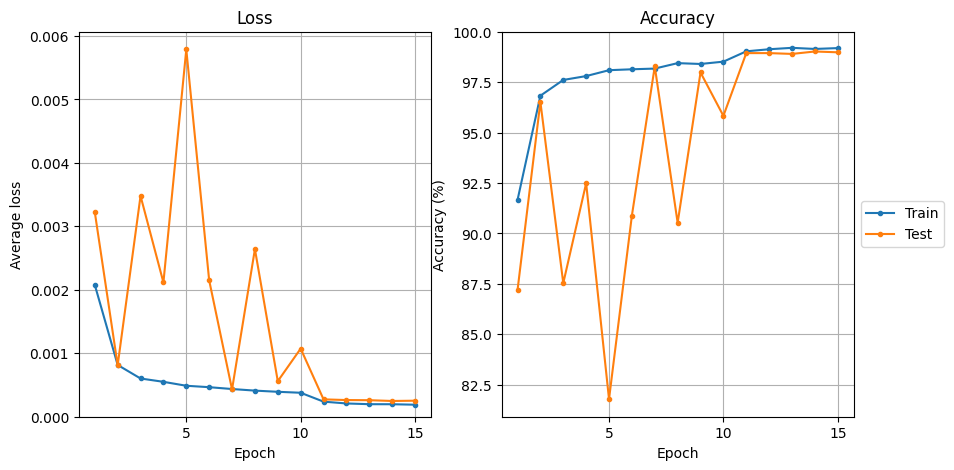

In [12]:
utils.plot_curves(results)